<a href="https://colab.research.google.com/github/epg900/Apex-Report-Printing/blob/master/V2Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title V2Ray Server
import json, base64, uuid, os, re, time
from IPython.display import HTML, clear_output
from threading import Timer
from subprocess import Popen , PIPE

!pip install pyqrcode
clear_output()
import pyqrcode

if os.path.isdir('server'):
  os.system('rm -r server')
os.system('mkdir server')

%cd server

!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
clear_output()
!wget https://github.com/v2fly/v2ray-core/releases/download/v4.45.2/v2ray-linux-64.zip
clear_output()
!dpkg -i cloudflared-linux-amd64.deb
clear_output()
!unzip v2ray-linux-64.zip
clear_output()

os.remove("config.json")
idx=str(uuid.uuid4())
!chmod +x v2ray

config='{"log":{"access":"","error":"","loglevel":"warning"},"inbound":{"protocol":"vmess","port":%s,"settings":{"clients":[{"id":"%s","alterId":64}]},"streamSettings":{"network":"ws"}},"inboundDetour":[],"outbound":{"protocol":"freedom","settings":{}}}' % (str(9910),idx)
with open("config.json", "w") as f:
  f.write(config)

clear_output()

!pkill v2ray
!pkill cloudflared
!pkill ngrok

!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

Popen("./v2ray run".split(), cwd='./', env={'V2RAY_VMESS_AEAD_FORCED':'false'})
#Popen("cloudflared tunnel --url 127.0.0.1:9910 --logfile cloudflared.log".split(), stdout=PIPE, stdin=PIPE, stderr=PIPE, universal_newlines=True)
#time.sleep(5)
#ff=open("cloudflared.log", "r")
#txt=ff.read()
#ff.close()
#addr=re.findall("https://(.*?.trycloudflare.com)",txt)
!mkdir '/root/.config/ngrok'
with open('/root/.config/ngrok/ngrok.yml','w') as f:
 f.write('''authtoken: 1nrjUau4uq4HtqUJIcbGCUmvRVT_3dLq4GMbE3BPtwHh11pnS
region: us
update: false
update_channel: stable
web_addr: localhost:8098
tunnels:
   v2ray:
     addr: 9910
     proto: http
     inspect: false
''')


!ngrok config upgrade
!ngrok config check

#from google.colab.output import eval_js
#url=eval_js("google.colab.kernel.proxyPort(9910)")

#!pip install pyngrok
#from pyngrok import ngrok, conf

#conf.get_default().auth_token = '1nrjUau4uq4HtqUJIcbGCUmvRVT_3dLq4GMbE3BPtwHh11pnS'
#conf.get_default().web_addr = 'localhost:8097'
#conf.get_default().config_path = "/root/222.yml"
#url = ngrok.connect("9910").public_url
#addr=re.findall("https://(.*?.ngrok-free.app)",url)

Popen("ngrok http 9910".split(), stdout=PIPE, stdin=PIPE, stderr=PIPE, shell=True)
url="aaa"


d=json.loads('{"add":"{0}","aid":"64","host":"","id":"{1}","net":"ws","path":"","port":"80","ps":"1","tls":"","type":"none","v":"2"}')
d["add"] = url
d["id"] = idx

#clear_output()

print(json.dumps(d))
!curl localhost:8097/api/tunnels

config="vmess://"+base64.b64encode(json.dumps(d).encode()).decode("utf-8")
#print(config)
url = pyqrcode.create(config)
url.svg('qrcode.svg', scale=8)
imgfile=base64.b64encode(open("qrcode.svg","rb").read()).decode('ascii')

display(HTML("<center><img width='270px' height='270px'  src='data:image/svg+xml;base64,{}' /></center>".format(imgfile)))
html_text = '''<center><input type="hidden" value="{}" id="clipborad-text">
                <button onclick="copyToClipboard()">Copy Config</button>
                <script>
                function copyToClipboard() {{
                    var copyText = document.getElementById("clipborad-text");
                    copyText.select();
                    navigator.clipboard.writeText(copyText.value);
                    alert("Copied the text: " + copyText.value);
                }}
                </script></center>'''.format(config)
display(HTML(html_text))
#time.sleep(7200)
#while True: pass


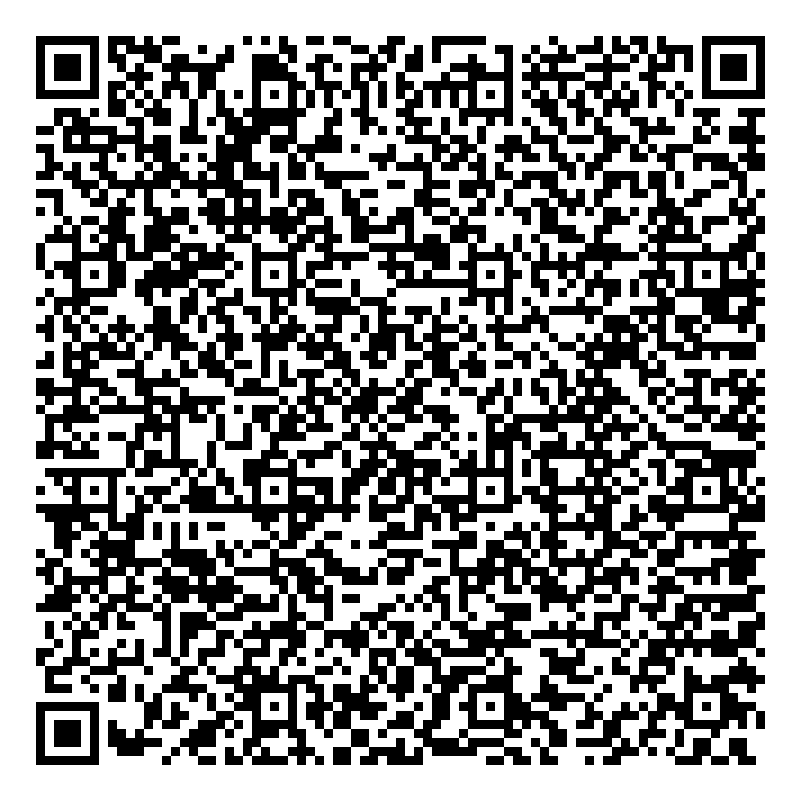

In [ ]:
# @title V2Ray Server ngrok


USE_FREE_TOKEN = False
TOKEN = "1nrjUau4uq4HtqUJIcbGCUmvRVT_3dLq4GMbE3BPtwHh11pnS"
REGION = "US"
ID=""
DEFAULT_SET = True
PORT_FORWARD = "ngrok"
RUN_WITH_LATEST = False

import json
import base64
import uuid
import os, subprocess
import urllib.request
import re
from IPython.display import HTML, clear_output
from subprocess import Popen, PIPE, run
import pandas as pd
import requests

HOME = os.path.expanduser("~")
if not os.path.exists(f"{HOME}/.ipython/ocr.py"):
    hCode = "https://raw.githubusercontent.com/biplobsd/" \
                "OneClickRun/master/res/ocr.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ocr.py")

from ocr import PortForward_wrapper, findPackageR, textAn, findProcess

def show_qr(text, v=True):
  try:
    from MyQR import myqr
  except:
    Popen("pip install myqr".split()).wait()
  Popen(["myqr",text]+"--version 5 --level H -n qrcode.png -d /tmp".split()).wait()
  if v:
    from PIL import Image
    im = Image.open("/tmp/qrcode.png")
    os.remove("/tmp/qrcode.png")
    im.show()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.axis('off')
    plt.show()
  else:
    with open("/tmp/qrcode.png", "rb") as imageFile:
      imgb64 = base64.b64encode(imageFile.read())
    os.remove("/tmp/qrcode.png")
    return imgb64

def v2ray(id=None, port=9999):
  if RUN_WITH_LATEST:
    found = findPackageR('v2fly/v2ray-core', 'v2ray-linux-64.zip', all_=True)
    downUrl = found['assets']['browser_download_url']
    tagName = found['tag_name']
  else:
    downUrl = 'https://github.com/v2fly/v2ray-core/releases/download/v4.45.2/v2ray-linux-64.zip'
    tagName = 'v4.45.2'

  print(f"Installing v2ray {tagName} ...")
  if not os.path.exists("tools/v2raybin"):
    os.system(f'mkdir -p -m 777 tools/v2raybin && cd tools/v2raybin  && curl -L -H "Cache-Control: no-cache" -o v2ray.zip {downUrl} && unzip v2ray.zip  && chmod +x v2ray  && rm -rf v2ray.zip  && chgrp -R 0 ../  && chmod -R g+rwX ../')
  CONFIG_JSON1="{\"log\":{\"access\":\"\",\"error\":\"\",\"loglevel\":\"warning\"},\"inbound\":{\"protocol\":\"vmess\",\"port\":"
  CONFIG_JSON2=",\"settings\":{\"clients\":[{\"id\":\""
  CONFIG_JSON3="\",\"alterId\":64}]},\"streamSettings\":{\"network\":\"ws\"}},\"inboundDetour\":[],\"outbound\":{\"protocol\":\"freedom\",\"settings\":{}}}"
  with open("tools/v2raybin/config.json", "w") as f:
    f.write(CONFIG_JSON1+str(port)+CONFIG_JSON2+id+CONFIG_JSON3)

  if not findProcess('./v2ray','run'):
    return Popen("./v2ray run".split(), cwd='tools/v2raybin/', env={'V2RAY_VMESS_AEAD_FORCED':'false'})

port=9910
!pkill v2ray
if not ID:
  ID=str(uuid.uuid4())
print("Setting up v2ray server ... ")
v2ray(ID,port)
print("Setting up tunnel ... ")

!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok
!mkdir '/root/.config/ngrok'
with open('/root/.config/ngrok/ngrok.yml','w') as f:
 f.write('''authtoken: 1nrjUau4uq4HtqUJIcbGCUmvRVT_3dLq4GMbE3BPtwHh11pnS
region: us
update: false
update_channel: stable
web_addr: localhost:8098
tunnels:
   v2ray:
     addr: 9910
     proto: http
     inspect: false
''')


!ngrok config upgrade
!ngrok config check
configPath='/root/.config/ngrok/ngrok.yml'
'''
subprocess.run(
                    f"ngrok start --config {configPath} --all &",
                    shell=False,
                    stdout=subprocess.PIPE,
                    stderr=subprocess.STDOUT,
                    cwd=None,
                ).stdout.decode("utf-8").strip()
'''
Popen(f"ngrok start --all --config {configPath} &".split(), stdout=PIPE, stdin=PIPE, stderr=PIPE, shell=False)

'''
Server = PortForward_wrapper(
    PORT_FORWARD, TOKEN, USE_FREE_TOKEN, [['v2ray', port, 'http']],
    REGION.lower(), [f"{HOME}/.ngrok2/V2ray.yml", 8097]
).start('v2ray', displayB=False)
'''
d=json.loads('{"add":"{0}","aid":"64","host":"","id":"{1}","net":"ws","path":"","port":"80","ps":"1","tls":"","type":"none","v":"2"}')
d["add"]="aaa"#re.search("(?<=//).*?(/|$)",Server["url"]).group()
d["id"]=ID
clear_output()
# print(d)
config="vmess://"+base64.b64encode(json.dumps(d).encode()).decode("utf-8")
# print(config)
imgfile = show_qr(config, v=False).decode()
display(HTML("<center><img width='270px' height='270px'  src='data:image/png;base64,{}' /></center>".format(imgfile)))
html_text = '''<center><input type="hidden" value="{}" id="clipborad-text">
                <button onclick="copyToClipboard()">Copy Config</button>
                <script>
                function copyToClipboard() {{
                    var copyText = document.getElementById("clipborad-text");
                    copyText.select();
                    navigator.clipboard.writeText(copyText.value);
                    alert("Copied the text: " + copyText.value);
                }}
                </script></center>'''.format(config)
display(HTML(html_text))
#time.sleep(7200)
#while True: pass

In [ ]:

!cat /root/.config/ngrok/ngrok.yml

In [ ]:
!ps aux

In [ ]:
!ngrok config upgrade
!ngrok config check

In [ ]:
Popen("ngrok start v2ray".split(), stdout=PIPE, stdin=PIPE, stderr=PIPE, universal_newlines=True)

<Popen: returncode: None args: ['ngrok', 'start', 'v2ray']>

In [ ]:
!curl localhost:8098/api/tunnels

In [ ]:
# @title cloudflare test
from threading import Timer
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
# target task function
def task(message):
    # report the custom message
    !./cloudflared-linux-amd64 tunnel --url localhost:8000
    #!socat TCP4-LISTEN:34.30.64.213,fork TCP:http://localhost:8000

# create a thread timer object
timer = Timer(3, task,args=('Hello world',))
# start the timer object
timer.start()
!python -m http.server

In [ ]:
# @title cloudflare install
!sudo mkdir -p --mode=0755 /usr/share/keyrings
!curl -fsSL https://pkg.cloudflare.com/cloudflare-main.gpg | sudo tee /usr/share/keyrings/cloudflare-main.gpg >/dev/null

!echo 'deb [signed-by=/usr/share/keyrings/cloudflare-main.gpg] https://pkg.cloudflare.com/cloudflared bookworm main' | sudo tee /etc/apt/sources.list.d/cloudflared.list


!sudo apt-get update && sudo apt-get install cloudflared

In [ ]:
# @title colab
!curl https://ipecho.net/plain
print('\n')
from google.colab.output import eval_js
url=eval_js("google.colab.kernel.proxyPort(9910)")
print(f'{url}\n')
!python -m http.server 9910

In [ ]:
!pip install pyngrok
from pyngrok import ngrok, conf

conf.get_default().auth_token = '1nrjUau4uq4HtqUJIcbGCUmvRVT_3dLq4GMbE3BPtwHh11pnS'

url = ngrok.connect("8000","tcp").public_url
print(url)
!python -m http.server